### Матричные факторизации

В данной работе вам предстоит познакомиться с практической стороной матричных разложений.
Работа поделена на 4 задания:
1. Вам необходимо реализовать SVD разложения используя SGD на explicit данных
2. Вам необходимо реализовать матричное разложения используя ALS на implicit данных
3. Вам необходимо реализовать матричное разложения используя BPR(pair-wise loss) на implicit данных
4. Вам необходимо реализовать матричное разложения используя WARP(list-wise loss) на implicit данных

Мягкий дедлайн 28 Сентября (пишутся замечания, выставляется оценка, есть возможность исправить до жесткого дедлайна)

Жесткий дедлайн 5 Октября (Итоговая проверка)

In [4]:
import implicit
import pandas as pd
import numpy as np
import scipy.sparse as sp

from lightfm.datasets import fetch_movielens

/usr/local/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


В данной работе мы будем работать с explicit датасетом movieLens, в котором представленны пары user_id movie_id и rating выставленный пользователем фильму

Скачать датасет можно по ссылке https://grouplens.org/datasets/movielens/1m/

In [5]:
ratings = pd.read_csv('ml-1m/ratings.dat', delimiter='::', header=None, 
        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
        usecols=['user_id', 'movie_id', 'rating'], engine='python')

In [6]:
movie_info = pd.read_csv('ml-1m/movies.dat', delimiter='::', header=None, 
        names=['movie_id', 'name', 'category'], engine='python')

Explicit данные

In [7]:
ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


In [34]:
explicit_ratings = sp.csc_matrix((ratings['rating'], (ratings['user_id'], ratings['movie_id'])))

In [39]:
ratings['user_id'].nunique()

6040

Для того, чтобы преобразовать текущий датасет в Implicit, давайте считать что позитивная оценка это оценка >=4

In [8]:
implicit_ratings = ratings.loc[(ratings['rating'] >= 4)]

In [9]:
implicit_ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
3,1,3408,4
4,1,2355,5
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4
10,1,595,5
11,1,938,4
12,1,2398,4


Удобнее работать с sparse матричками, давайте преобразуем DataFrame в CSR матрицы

In [10]:
users = implicit_ratings["user_id"]
movies = implicit_ratings["movie_id"]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
user_item_t_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

В качестве примера воспользуемся ALS разложением из библиотеки implicit

Зададим размерность латентного пространства равным 64, это же определяет размер user/item эмбедингов

In [11]:
model = implicit.als.AlternatingLeastSquares(factors=64, iterations=100, calculate_training_loss=True)

В качестве loss здесь всеми любимый RMSE

In [12]:
model.fit(user_item_t_csr)

Построим похожие фильмы по 1 movie_id = Истории игрушек

In [13]:
movie_info.head(5)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
get_similars = lambda item_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                        for x in model.similar_items(item_id)]

Как мы видим, симилары действительно оказались симиларами.

Качество симиларов часто является хорошим способом проверить качество алгоритмов.

P.S. Если хочется поглубже разобраться в том как разные алгоритмы формируют разные латентные пространства, рекомендую загружать полученные вектора в tensorBoard и смотреть на сформированное пространство

In [15]:
get_similars(1, model)

['0    Toy Story (1995)',
 '3045    Toy Story 2 (1999)',
 "2286    Bug's Life, A (1998)",
 '33    Babe (1995)',
 '584    Aladdin (1992)',
 '2315    Babe: Pig in the City (1998)',
 '1526    Hercules (1997)',
 '360    Lion King, The (1994)',
 '3817    Went to Coney Island on a Mission From God... ...',
 '1838    Mulan (1998)']

Давайте теперь построим рекомендации для юзеров

Как мы видим юзеру нравится фантастика, значит и в рекомендациях ожидаем увидеть фантастику

In [16]:
get_user_history = lambda user_id, implicit_ratings : [movie_info[movie_info["movie_id"] == x]["name"].to_string() 
                                            for x in implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"]]

In [17]:
get_user_history(4, implicit_ratings)

['3399    Hustler, The (1961)',
 '2882    Fistful of Dollars, A (1964)',
 '1196    Alien (1979)',
 '1023    Die Hard (1988)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1959    Saving Private Ryan (1998)',
 '476    Jurassic Park (1993)',
 '1180    Raiders of the Lost Ark (1981)',
 '1885    Rocky (1976)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '3349    Thelma & Louise (1991)',
 '3633    Mad Max (1979)',
 '2297    King Kong (1933)',
 '1366    Jaws (1975)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '2623    Run Lola Run (Lola rennt) (1998)',
 '2878    Goldfinger (1964)',
 '1220    Terminator, The (1984)']

Получилось! 

Мы действительно порекомендовали пользователю фантастику и боевики, более того встречаются продолжения тех фильмов, которые он высоко оценил

In [18]:
get_recommendations = lambda user_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                               for x in model.recommend(user_id, user_item_csr)]

In [19]:
get_recommendations(4, model)

['585    Terminator 2: Judgment Day (1991)',
 '1284    Butch Cassidy and the Sundance Kid (1969)',
 '1271    Indiana Jones and the Last Crusade (1989)',
 '1178    Star Wars: Episode V - The Empire Strikes Back...',
 '2502    Matrix, The (1999)',
 '1182    Aliens (1986)',
 '1884    French Connection, The (1971)',
 '847    Godfather, The (1972)',
 '3402    Close Encounters of the Third Kind (1977)',
 '3458    Predator (1987)']

Теперь ваша очередь реализовать самые популярные алгоритмы матричных разложений

Что будет оцениваться:
1. Корректность алгоритма
2. Качество получившихся симиларов
3. Качество итоговых рекомендаций для юзера

### Задание 1. Не использую готовые решения, реализовать SVD разложение используя SGD на explicit данных

In [508]:
from __future__ import annotations
import numpy as np
from abc import ABC, abstractmethod
from typing import List
from scipy.sparse import csr_matrix


class MatrixFactorizationBase(ABC):
    def __init__(self, factors=128, iterations=100, l2_regularization=5e-2, compute_loss=False):
        self.factors = factors
        self.iterations = iterations
        self.l2_regularization = l2_regularization

        self.item_factors: np.array = None
        self.user_factors: np.array = None

        self.item_norms: np.array = None
        self.user_norms: np.array = None

        self._compute_loss = compute_loss
        self._loss_by_iterations = []

    @abstractmethod
    def fit(self, user_items: csr_matrix) -> MatrixFactorizationBase:
        pass

    def _init_matrices(self, n_items, n_users):
        self.item_factors = np.random.uniform(0, 1 / np.sqrt(self.factors), (n_items, self.factors))
        self.user_factors = np.random.uniform(0, 1 / np.sqrt(self.factors), (n_users, self.factors))

    def _compute_factors_norms(self):
        self.item_norms = np.linalg.norm(self.item_factors, axis=1)
        self.user_norms = np.linalg.norm(self.user_factors, axis=1)

    def _compute_l2_norm(self, vector):
        return np.power(np.linalg.norm(vector), 2)

    def similar_items(self, item_id: int, top_k: int = 10):
        """
        By cosine similarity
        :param top_k:
        :param item_id:
        :return:
        """
        item_vector = self.item_factors[item_id]
        item_norm = self.item_norms[item_id]
        cos_similar = self.item_factors.dot(item_vector) / (self.item_norms * item_norm + 1e-8)
        top_k_similar = np.argsort(cos_similar)[-top_k:][::-1]

        return list(zip(top_k_similar.tolist(), cos_similar.take(top_k_similar).tolist()))

    def recommend(self, user_id: int, user_items: List[int] = None, top_k: int = 10):
        """
        By top dot product with item_factors
        :param top_k:
        :param user_id:
        :param user_items: items to exclude
        :return:
        """
        if not user_items:
            user_items = []

        user_vector = self.user_factors[user_id]
        user_products = self.item_factors.dot(user_vector)
        top_k_recommend = np.delete(np.argsort(user_products), user_items, axis=0)[-top_k:][::-1]

        return list(zip(top_k_recommend.tolist(), user_products.take(top_k_recommend).tolist()))


In [512]:
import numpy as np
from tqdm import tqdm
# from recommender_systems.matrix_factorization_base import MatrixFactorizationBase


class SVD(MatrixFactorizationBase):
    """
    By https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)
    """
    def __init__(self, factors: int = 128, iterations: int = 100, learning_rate: float = 5e-5,
                 l2_regularization: float = 1e-3, compute_loss=False):
        super().__init__(factors, iterations, l2_regularization, compute_loss)
        self.learning_rate = learning_rate

        self._user_bias = None
        self._item_bias = None

    def fit(self, user_items):
        n_users, n_items = user_items.shape
        self._init_matrices(n_items, n_users)

        for _ in tqdm(range(self.iterations), position=0, leave=True):
            residual = self._residual(user_items)
            self.user_factors -= self.learning_rate * self._grad_user(residual)
            self._user_bias -= self.learning_rate * self._grad_user_bias(residual)
            self.item_factors -= self.learning_rate * self._grad_item(residual)
            self._item_bias -= self.learning_rate * self._grad_item_bias(residual)

            if self._compute_loss:
                self._loss_by_iterations.append(self._loss(residual))
                print(self._loss_by_iterations)

        self._compute_factors_norms()

        return self

    def _init_matrices(self, n_items, n_users):
        super(SVD, self)._init_matrices(n_items, n_users)

        self._item_bias = np.random.uniform(0, 1 / np.sqrt(self.factors), (n_items, 1))
        self._user_bias = np.random.uniform(0, 1 / np.sqrt(self.factors), (n_users, 1))

    def _residual(self, user_items):
        return (
            self.user_factors @ self.item_factors.T + self._user_bias + self._item_bias.T - user_items
        )

    def _loss(self, residual):
        return (
            np.power(residual, 2).sum() +
            self.l2_regularization * (
                self._compute_l2_norm(self._user_bias) + self._compute_l2_norm(self._item_bias) +
                self._compute_l2_norm(self.user_factors) + self._compute_l2_norm(self.item_factors)
            )
        )

    def _grad_user(self, residual):
        return 2 * (residual @ self.item_factors + self.l2_regularization * self.user_factors)

    def _grad_user_bias(self, residual):
        return 2 * (residual.mean(axis=1) + self.l2_regularization * self._user_bias)

    def _grad_item(self, residual):
        return 2 * (residual.T @ self.user_factors + self.l2_regularization * self.item_factors)

    def _grad_item_bias(self, residual):
        return 2 * (residual.T.mean(axis=1) + self.l2_regularization * self._item_bias)


In [515]:
svd = SVD(learning_rate=0.0001, compute_loss=True)

svd.fit(explicit_ratings)

  1%|          | 1/100 [00:05<09:29,  5.75s/it]

[14428659.222999433]


  2%|▏         | 2/100 [00:10<09:05,  5.56s/it]

[14428659.222999433, 12976263.509254532]


  3%|▎         | 3/100 [00:15<08:33,  5.29s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004]


  4%|▍         | 4/100 [00:21<08:45,  5.47s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709]


  5%|▌         | 5/100 [00:26<08:14,  5.20s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677]


  6%|▌         | 6/100 [00:27<06:29,  4.14s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127]


  7%|▋         | 7/100 [00:29<05:15,  3.40s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194]


  8%|▊         | 8/100 [00:30<04:24,  2.87s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038]


  9%|▉         | 9/100 [00:32<03:46,  2.49s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223]


 10%|█         | 10/100 [00:34<03:19,  2.22s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343]


 11%|█         | 11/100 [00:35<02:59,  2.02s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935]


 12%|█▏        | 12/100 [00:37<02:47,  1.90s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564]


 13%|█▎        | 13/100 [00:38<02:36,  1.80s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774]


 14%|█▍        | 14/100 [00:40<02:36,  1.82s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304]


 15%|█▌        | 15/100 [00:42<02:27,  1.73s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091]


 16%|█▌        | 16/100 [00:43<02:23,  1.71s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016]


 17%|█▋        | 17/100 [00:45<02:23,  1.73s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802]


 18%|█▊        | 18/100 [00:47<02:20,  1.72s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406]


 19%|█▉        | 19/100 [00:48<02:14,  1.66s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962]


 20%|██        | 20/100 [00:50<02:09,  1.61s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404]


 21%|██        | 21/100 [00:52<02:06,  1.60s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502]


 22%|██▏       | 22/100 [00:53<02:03,  1.58s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414]


 23%|██▎       | 23/100 [00:55<02:01,  1.58s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862]


 24%|██▍       | 24/100 [00:56<01:59,  1.57s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648]


 25%|██▌       | 25/100 [00:58<01:58,  1.58s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912]


 26%|██▌       | 26/100 [00:59<01:57,  1.59s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853]


 27%|██▋       | 27/100 [01:01<01:55,  1.58s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296]


 28%|██▊       | 28/100 [01:02<01:52,  1.57s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523]


 29%|██▉       | 29/100 [01:04<01:53,  1.59s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108]


 30%|███       | 30/100 [01:06<01:52,  1.61s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587]


 31%|███       | 31/100 [01:08<01:53,  1.65s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024]


 32%|███▏      | 32/100 [01:09<01:50,  1.63s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554]


 33%|███▎      | 33/100 [01:11<01:47,  1.60s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741]


 34%|███▍      | 34/100 [01:12<01:42,  1.56s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797]


 35%|███▌      | 35/100 [01:14<01:38,  1.51s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933]


 36%|███▌      | 36/100 [01:15<01:36,  1.50s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719]


 37%|███▋      | 37/100 [01:17<01:35,  1.52s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259]


 38%|███▊      | 38/100 [01:18<01:32,  1.49s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281]


 39%|███▉      | 39/100 [01:19<01:29,  1.46s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945]


 40%|████      | 40/100 [01:21<01:26,  1.44s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454]


 41%|████      | 41/100 [01:22<01:24,  1.43s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051]


 42%|████▏     | 42/100 [01:24<01:22,  1.43s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008]


 43%|████▎     | 43/100 [01:25<01:20,  1.42s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288]


 44%|████▍     | 44/100 [01:26<01:19,  1.42s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734]


 45%|████▌     | 45/100 [01:28<01:17,  1.42s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314]


 46%|████▌     | 46/100 [01:29<01:16,  1.42s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651]


 47%|████▋     | 47/100 [01:31<01:15,  1.42s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847]


 48%|████▊     | 48/100 [01:32<01:13,  1.42s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277]


 49%|████▉     | 49/100 [01:34<01:12,  1.42s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838]


 50%|█████     | 50/100 [01:35<01:11,  1.42s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488]


 51%|█████     | 51/100 [01:36<01:10,  1.43s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515]


 52%|█████▏    | 52/100 [01:38<01:08,  1.43s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 53%|█████▎    | 53/100 [01:39<01:07,  1.43s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 54%|█████▍    | 54/100 [01:41<01:05,  1.43s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 55%|█████▌    | 55/100 [01:42<01:04,  1.43s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 56%|█████▌    | 56/100 [01:44<01:03,  1.43s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 57%|█████▋    | 57/100 [01:45<01:01,  1.43s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 58%|█████▊    | 58/100 [01:46<01:00,  1.43s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 59%|█████▉    | 59/100 [01:48<00:58,  1.43s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 60%|██████    | 60/100 [01:49<00:57,  1.45s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 61%|██████    | 61/100 [01:51<00:56,  1.45s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 62%|██████▏   | 62/100 [01:52<00:55,  1.45s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 63%|██████▎   | 63/100 [01:54<00:53,  1.45s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 64%|██████▍   | 64/100 [01:55<00:52,  1.45s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 65%|██████▌   | 65/100 [01:57<00:50,  1.45s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 66%|██████▌   | 66/100 [01:58<00:49,  1.44s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 67%|██████▋   | 67/100 [01:59<00:47,  1.45s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 68%|██████▊   | 68/100 [02:01<00:46,  1.44s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 69%|██████▉   | 69/100 [02:02<00:44,  1.44s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 70%|███████   | 70/100 [02:04<00:43,  1.44s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 71%|███████   | 71/100 [02:05<00:41,  1.44s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 72%|███████▏  | 72/100 [02:07<00:40,  1.45s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 73%|███████▎  | 73/100 [02:08<00:39,  1.45s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 74%|███████▍  | 74/100 [02:10<00:37,  1.44s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 75%|███████▌  | 75/100 [02:11<00:36,  1.44s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 76%|███████▌  | 76/100 [02:13<00:34,  1.45s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 77%|███████▋  | 77/100 [02:14<00:35,  1.53s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 78%|███████▊  | 78/100 [02:16<00:33,  1.54s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 79%|███████▉  | 79/100 [02:17<00:31,  1.51s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 80%|████████  | 80/100 [02:19<00:29,  1.49s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 81%|████████  | 81/100 [02:20<00:28,  1.48s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 82%|████████▏ | 82/100 [02:22<00:26,  1.48s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 83%|████████▎ | 83/100 [02:23<00:24,  1.47s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 84%|████████▍ | 84/100 [02:24<00:23,  1.46s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 85%|████████▌ | 85/100 [02:26<00:22,  1.50s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 86%|████████▌ | 86/100 [02:28<00:21,  1.51s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 87%|████████▋ | 87/100 [02:29<00:19,  1.50s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 88%|████████▊ | 88/100 [02:31<00:17,  1.49s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 89%|████████▉ | 89/100 [02:32<00:16,  1.48s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 90%|█████████ | 90/100 [02:33<00:14,  1.47s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 91%|█████████ | 91/100 [02:35<00:13,  1.46s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 92%|█████████▏| 92/100 [02:36<00:11,  1.47s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 93%|█████████▎| 93/100 [02:38<00:10,  1.48s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 94%|█████████▍| 94/100 [02:39<00:08,  1.47s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 95%|█████████▌| 95/100 [02:41<00:07,  1.46s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 96%|█████████▌| 96/100 [02:42<00:05,  1.46s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 97%|█████████▋| 97/100 [02:44<00:04,  1.46s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 98%|█████████▊| 98/100 [02:45<00:02,  1.46s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

 99%|█████████▉| 99/100 [02:47<00:01,  1.47s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

100%|██████████| 100/100 [02:48<00:00,  1.69s/it]

[14428659.222999433, 12976263.509254532, 12150205.369988004, 11487554.301907709, 11030499.753017677, 10792925.485135127, 10694345.22396194, 10656270.827711038, 10640861.244591223, 10633920.266455343, 10630222.364395935, 10627741.810275564, 10625641.708421774, 10623543.007283304, 10621243.018771091, 10618601.15532016, 10615489.227290802, 10611766.976293406, 10607267.177520962, 10601783.8415404, 10595060.76660502, 10586779.320459414, 10576545.213085862, 10563874.749348648, 10548181.934942912, 10528769.057594853, 10504825.114990296, 10475438.712666523, 10439634.497545108, 10396443.899822587, 10345020.028792024, 10284800.019463554, 10215702.699368741, 10138324.326914797, 10054066.760496933, 9965118.28673719, 9874231.550693259, 9784316.538858281, 9697961.925280945, 9617051.0448454, 9542598.311931051, 9474818.603298008, 9413338.90820288, 9357435.088290734, 9306220.673729314, 9258774.395844651, 9214224.999999847, 9171811.175690277, 9130921.047594838, 9091107.947835488, 9052081.58444515, 90136

In [516]:
get_similars(1, svd)

['0    Toy Story (1995)',
 '3045    Toy Story 2 (1999)',
 '584    Aladdin (1992)',
 '33    Babe (1995)',
 "2286    Bug's Life, A (1998)",
 '1245    Groundhog Day (1993)',
 '360    Lion King, The (1994)',
 '2252    Pleasantville (1998)',
 '591    Beauty and the Beast (1991)',
 '2618    Tarzan (1999)']

### Задание 2. Не использую готовые решения, реализовать матричное разложение используя ALS на implicit данных

In [517]:
import numpy as np
from tqdm import tqdm
# from recommender_systems.matrix_factorization_base import MatrixFactorizationBase


class ALS(MatrixFactorizationBase):
    """
    By http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf
    """
    def fit(self, user_items):
        n_users, n_items = user_items.shape
        self._init_matrices(n_items, n_users)

        for _ in tqdm(range(self.iterations), position=0, leave=True):
            self.user_factors = self._grad_user(user_items).T
            self.item_factors = self._grad_item(user_items).T

            if self._compute_loss:
                self._loss_by_iterations.append(self._loss(user_items))

        self._compute_factors_norms()

    def _loss(self, user_items):
        return (
            np.power(user_items - self.user_factors @ self.item_factors.T, 2).sum() +
            self.l2_regularization * (self._compute_l2_norm(self.user_factors) + self._compute_l2_norm(self.item_factors))
        )

    def _grad_user(self, user_items):
        YtY = self.item_factors.T @ self.item_factors

        return (
            np.linalg.inv((YtY + self.l2_regularization * np.eye(self.factors))) @
            (self.item_factors.T @ user_items.T)
        )

    def _grad_item(self, user_items):
        UtU = self.user_factors.T @ self.user_factors

        return (
            np.linalg.inv(UtU + self.l2_regularization * np.eye(self.factors)) @
            (self.user_factors.T @ user_items)
        )


In [518]:
als = ALS(128, 100, 5e-2)

als.fit(user_item_t_csr.T)

100%|██████████| 100/100 [00:06<00:00, 15.57it/s]


In [519]:
get_similars(1, als)

['0    Toy Story (1995)',
 '3045    Toy Story 2 (1999)',
 '591    Beauty and the Beast (1991)',
 '1445    Best Men (1997)',
 '584    Aladdin (1992)',
 '360    Lion King, The (1994)',
 '2468    Beyond the Poseidon Adventure (1979)',
 '1938    Polish Wedding (1998)',
 '314    Santa Clause, The (1994)',
 '1526    Hercules (1997)']

### Задание 3. Не использую готовые решения, реализовать матричное разложение BPR на implicit данных

In [744]:
import numpy as np
from tqdm import tqdm
# from recommender_systems.matrix_factorization_base import MatrixFactorizationBase


class BPR(MatrixFactorizationBase):
    """
    By https://arxiv.org/pdf/1205.2618.pdf
    """
    def __init__(self, factors: int = 128, iterations: int = 100, learning_rate: float = 5e-5,
                 l2_regularization: float = 5e-2, compute_loss=False):
        super().__init__(factors, iterations, l2_regularization, compute_loss)
        self.learning_rate = learning_rate

    def fit(self, user_items):
        n_users, n_items = user_items.shape
        self._init_matrices(n_items, n_users)

        for i in tqdm(np.random.choice(range(n_users), self.iterations, True), position=0, leave=True):
            triplet = self._get_random_comparison_triplet(user_items, i, n_items)
            if not triplet:
                continue
            u_id, i_id, j_id = triplet

            x_uij = self._compute_x_uij(u_id, i_id, j_id)

            self.user_factors[u_id] -= self.learning_rate * self._grad_theta(
                x_uij, self._grad_theta_u(i_id, j_id), self.user_factors[u_id]
            )
            self.item_factors[i_id] -= self.learning_rate * self._grad_theta(
                x_uij, self._grad_theta_i(u_id), self.item_factors[i_id]
            )
            self.item_factors[j_id] -= self.learning_rate * self._grad_theta(
                x_uij, self._grad_theta_j(u_id), self.item_factors[j_id]
            )

            if self._compute_loss:
                self._loss_by_iterations.append(self._loss(triplet))
            
        self._compute_factors_norms()

    def _get_random_comparison_triplet(self, user_items, random_u_id, n_items):
        positive_user_items = set(user_items[random_u_id].nonzero()[1])
        negative_user_items = set(range(n_items)) - positive_user_items
        # (u_id, i_id, j_id) : i_id > j_id
        if not positive_user_items:
            return tuple()
        return random_u_id, np.random.choice(list(positive_user_items)), np.random.choice(list(negative_user_items))

    def _compute_x_uij(self, u_id, i_id, j_id):
        return (
            np.dot(self.user_factors[u_id], self.item_factors[i_id]) -
            np.dot(self.user_factors[u_id], self.item_factors[j_id])
        )

    def _loss(self, triplet):
        return - (
            self._sigmoid(self._compute_x_uij(*triplet)) -
            self.l2_regularization * (self._compute_l2_norm(self.user_factors) + self._compute_l2_norm(self.item_factors))
        )

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _grad_theta(self, x_uij, grad_x_uij_by_theta, theta):
        return np.exp(-x_uij) / (1 + np.exp(-x_uij)) * grad_x_uij_by_theta + self.l2_regularization * theta

    def _grad_theta_u(self, i_id, j_id):
        return self.item_factors[i_id] - self.item_factors[j_id]

    def _grad_theta_i(self, u_id):
        return self.user_factors[u_id]

    def _grad_theta_j(self, u_id):
        return -self.user_factors[u_id]


In [761]:
bpr = BPR(128, 100000, learning_rate=0.001, compute_loss=True)

bpr.fit(user_item_t_csr.T)
get_similars(1, bpr)

100%|██████████| 100000/100000 [03:18<00:00, 503.46it/s]


['0    Toy Story (1995)',
 '1872    Hamlet (1948)',
 '197    Umbrellas of Cherbourg, The (Parapluies de Che...',
 'Series([], )',
 '1921    Prom Night IV: Deliver Us From Evil (1992)',
 '976    Grace of My Heart (1996)',
 '3165    Train Ride to Hollywood (1978)',
 'Series([], )',
 '1747    Niagara, Niagara (1997)',
 '3108    Next Friday (1999)']

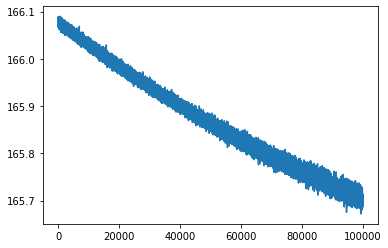

In [762]:
plt.plot(bpr._loss_by_iterations)

### Задание 4. Не использую готовые решения, реализовать матричное разложение WARP на implicit данных